# Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))       

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="dark")

/kaggle/input/Kannada-MNIST/sample_submission.csv
/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/test.csv


# Работа с данными

Считаем данные из csv-файла и проанализируем их.

In [13]:
df_train = pd.read_csv('../input/Kannada-MNIST/train.csv')
df_test = pd.read_csv('../input/Kannada-MNIST/test.csv')

In [15]:
df_train.head(3)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
df_test.head(3)

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Как можно заметить, данные представляют из себя значения каждого из пикселей в конкретной картинке. Изображения цифр имеют размер $28\times28=784$ пикселя, их значения мы и можем наблюдать в столбцах датафреймов. В тренировочном датасете есть еще правильные метки классов. 

Выведем распределение тренировочного датасета по меткам:

<AxesSubplot:xlabel='label', ylabel='count'>

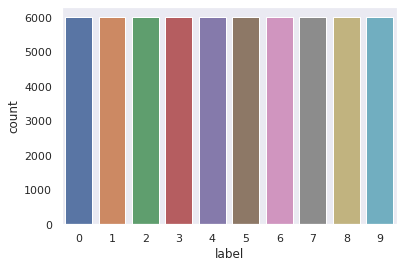

In [17]:
sns.countplot(x='label', data=df_train)

Все классы сбалансированы, что радует. Всего 6000 изображений каждой из цифр.

Проведем подготовку данных:

In [18]:
X_test = df_test.drop(columns='id')
X_train = df_train.drop(columns='label')
y_train = df_train['label']

Выведем первые 20 изображений:

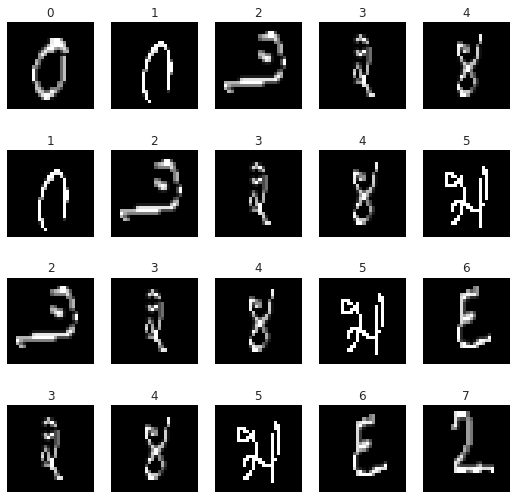

In [19]:
rows, cols = 4, 5

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(9,9))

for i in range(rows):
    for j in range(cols):
        ax[i][j].set_title(y_train[i+j])
        ax[i][j].axis('off')
        ax[i][j].imshow(X_train.iloc[i+j, :].values.reshape(28, 28), cmap='gray')

Разобьем тренировочную выборку на обучающую и валидационную, чтобы следить за появлением переобучения. Под валидационную выборку оставим $20\%$ данных.

Разбиваем с сохранением баланса классов:

In [20]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, stratify=y_train, random_state=42, test_size=0.02)

print(len(X_train))
print(len(X_dev))
print(len(X_test))

58800
1200
5000


<AxesSubplot:xlabel='label', ylabel='count'>

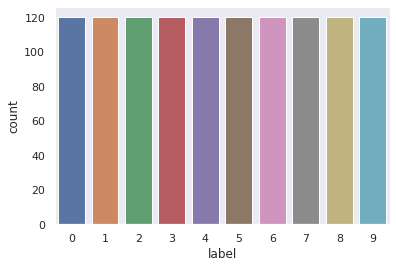

In [21]:
sns.countplot(x=y_dev.index, data=y_dev)

# Подготовка данных для обучени НС

Так как данные даны не в формате изображения, то проще всего будет написать собственный класс, наследованный от Dataset, который позволит удобно работать с pandas.DataFrame. 

Для этого надо переопределить функции __len__() и __getitem__():

In [24]:
class Dataset_df(Dataset): 
    def __init__(self,
                 images,
                 labels=None,
                 transform=None,
                ):
        self.X = images
        self.y = labels
        
        self.transform = transform
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = np.array(self.X.iloc[idx, :], dtype='uint8').reshape([28, 28, 1])
        if self.transform is not None:
            img = self.transform(img)
        
        if self.y is not None:
            return img, self.y.iloc[idx]
        
        return img

Данные из датафрейма представляются numpy-массивами размером $28\times28$. Затем с помощью трасформера массивы переводят в PIL картинки, после чего случайным образом изменяют их (это делается для усиления обучения НС) и переводят в torch.Tensor:

In [25]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
    transforms.ToTensor()
])

# Test data without augmentation
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

In [26]:
train_dataset = Dataset_df(X_train, y_train, train_transform)
val_dataset = Dataset_df(X_train, y_train, train_transform)

С помощью DataLoader удобно разбивать данные на бачи и учить нейронную сеть.

In [28]:
BATCH_SIZE = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Проверим, правильно ли все работает:

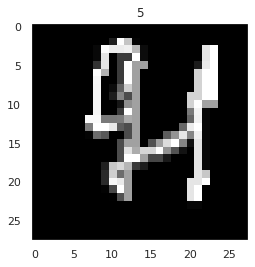

In [29]:
img, label = next(iter(train_loader))
plt.title(label[0].item())
plt.imshow(img[0].squeeze(), cmap="gray")

# Нейронная сеть

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [32]:
class ConvLayer(nn.Module):
    def __init__(self, input_size, output_size, kernel_size=3, stride=1, padding=1):
        super(ConvLayer, self).__init__()
        self.layer = nn.Sequential(nn.Conv2d(input_size, output_size, kernel_size=kernel_size, stride=stride, padding=padding),
                                   nn.ReLU(inplace=True),
                                   nn.BatchNorm2d(output_size))
    
    def forward(self, x):
        return self.layer(x)

class FCLayer(nn.Module):
    def __init__(self, input_size, output_size):
        super(FCLayer, self).__init__()
        self.ops = nn.Sequential(nn.Linear(input_size, output_size),
                                 nn.ReLU(inplace=True),
                                 nn.BatchNorm1d(output_size))
    
    def forward(self, x):
        return self.ops(x)

In [33]:
class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.conv1 = ConvLayer(1, 64)
        self.conv2 = ConvLayer(64, 64)
        self.conv3 = ConvLayer(64, 64)
        self.conv4 = ConvLayer(64, 64)
        self.conv5 = ConvLayer(64, 64)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv6 = ConvLayer(64, 64)
        self.conv7 = ConvLayer(64, 64)
        self.conv8 = ConvLayer(64, 64)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = FCLayer(64*7*7, 1024)
        self.fc2 = FCLayer(1024, 1024)
        self.fc3 = nn.Linear(1024, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.max_pool1(x)
        
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.max_pool2(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

Так как у нас задача классификации, то используем кросс-энтрапию в качестве критерия. Оптимизатор Адам с уменьшающейся скоростью обучения. Обучать будем на 16 эпохах, ибо ждать не хочется долго. 

In [35]:
learning_rate = 1e-2
num_epochs = 16

model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience = 5)

Проверим, нет ли ошибки в структуре НС:

In [36]:
X = torch.randn(64, 1, 28, 28).to(device)
model(X).shape

torch.Size([64, 10])

Запускаем обучение на 16 эпохах, а также контролируем ошибку на валидационном датасете:

In [37]:
%%time
total_step = len(train_loader)
loss_list = []
acc_list = []
val_list = []
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
            
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        print('Validation Accuracy of the model: {}%'.format((correct / total) * 100))
        val_list.append(correct / total)
        scheduler.step(val_list[-1])

Epoch [1/16], Step [100/919], Loss: 0.3432, Accuracy: 92.19%
Epoch [1/16], Step [200/919], Loss: 0.0264, Accuracy: 98.44%
Epoch [1/16], Step [300/919], Loss: 0.2404, Accuracy: 95.31%
Epoch [1/16], Step [400/919], Loss: 0.0881, Accuracy: 96.88%
Epoch [1/16], Step [500/919], Loss: 0.3646, Accuracy: 93.75%
Epoch [1/16], Step [600/919], Loss: 0.1683, Accuracy: 92.19%
Epoch [1/16], Step [700/919], Loss: 0.0805, Accuracy: 93.75%
Epoch [1/16], Step [800/919], Loss: 0.0776, Accuracy: 98.44%
Epoch [1/16], Step [900/919], Loss: 0.1121, Accuracy: 93.75%
Validation Accuracy of the model: 97.1734693877551%
Epoch [2/16], Step [100/919], Loss: 0.1015, Accuracy: 96.88%
Epoch [2/16], Step [200/919], Loss: 0.0217, Accuracy: 100.00%
Epoch [2/16], Step [300/919], Loss: 0.0078, Accuracy: 100.00%
Epoch [2/16], Step [400/919], Loss: 0.0787, Accuracy: 96.88%
Epoch [2/16], Step [500/919], Loss: 0.0072, Accuracy: 100.00%
Epoch [2/16], Step [600/919], Loss: 0.0661, Accuracy: 96.88%
Epoch [2/16], Step [700/919], 

# Анализ обучения НС

Графики ошибки и точности на тренировочном датасете и валидационном:

<AxesSubplot:>

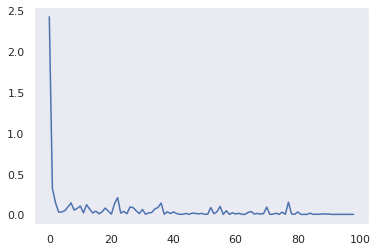

In [38]:
sns.lineplot(data = loss_list[::150])

<AxesSubplot:>

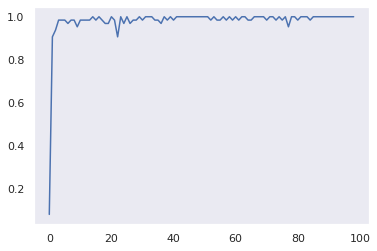

In [39]:
sns.lineplot(data=acc_list[::150])

<AxesSubplot:>

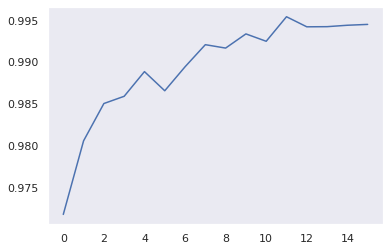

In [40]:
sns.lineplot(data=val_list)

Как видно из графиков, можно было и дальше обучать модель для улучшения ее качества, но целью было объяснение проделанных действий. Удачи!

# Предсказания для тестовой выборки

In [42]:
test_dataset = Dataset_df(X_test, transform=test_transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

In [43]:
model.eval()
predictions = []
with torch.no_grad():
    for data in tqdm(test_loader):
        data = data.to(device)
        output = torch.argmax(model(data), dim=1)
        predictions += list(output.data.cpu().numpy())

100%|██████████| 79/79 [00:01<00:00, 48.49it/s]


In [44]:
submission = pd.read_csv('../input/Kannada-MNIST/sample_submission.csv')
submission['label'] = predictions
submission.to_csv('submission.csv', index=False)
submission.head()

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7
